In [1]:
# Run the command below if necessary, for example with Google Colab
#!python3 -m pip install mxnet-cu110

In [2]:
# Global Libraries
import collections
import gluoncv as gcv
from gluoncv.utils.metrics.segmentation import SegmentationMetric
from importlib import reload
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import os
from sklearn import metrics
import time
from tqdm.notebook import tqdm

# MXNet ND-Arrays with Numpy notation
#mx.npx.set_np()

# Local Libraries
import pedestrian
import utils

# GPU mode
ctx = mx.gpu()

In [3]:
# Penn-Fudan Pedestrian Dataset
# https://www.cis.upenn.edu/~jshi/ped_html/

reload(pedestrian)

if not os.path.exists(pedestrian.PEDESTRIAN_FILE):
    !wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

pedestrian_path = os.getcwd()
pedestrian_dataset = pedestrian.PedestrianDataset(pedestrian_path,
                                                  is_segmentation_task=True)

Read 170 images with 423 pedestrians


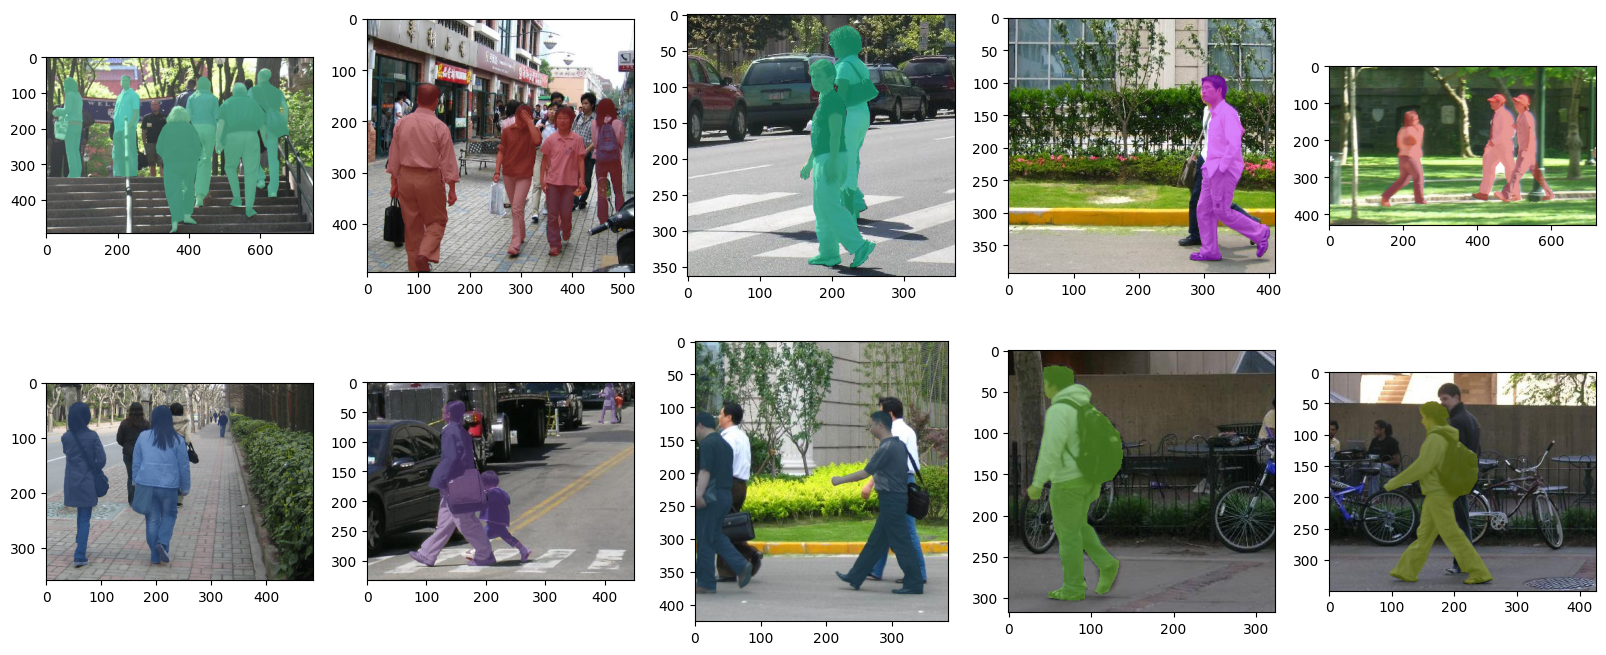

In [4]:
# Display 10 images from the dataset
# 5 x 2 grid
num_images_to_plot = 10
num_columns = 5

fig = plt.figure(figsize=(20, 8))

images_plotted = 0

number_pedestrians = 0

for (X, y) in pedestrian_dataset:
        
    # Format inputs
    image = X
    gt_mask = y

    axes = fig.add_subplot(2, 5, images_plotted + 1)
    masked_image = gcv.utils.viz.plot_mask(image, gt_mask)
    axes.imshow(masked_image)

    images_plotted += 1

    if images_plotted == num_images_to_plot:
        # We are done
        break


In [5]:
pspnet = gcv.model_zoo.get_model('psp_resnet101_coco', pretrained=True, ctx=ctx)

[08:31:25] ../src/base.cc:79: cuDNN lib mismatch: linked-against version 8600 != compiled-against version 8101.  Set MXNET_CUDNN_LIB_CHECKING=0 to quiet this warning.


self.crop_size 480


In [6]:
test_image, test_gt_mask = pedestrian_dataset[11]
transformed_test_image = gcv.data.transforms.presets.segmentation.test_transform(test_image, ctx)
masked_test_image = gcv.utils.viz.plot_mask(test_image, test_gt_mask)

In [7]:
output = pspnet.predict(transformed_test_image)

[08:31:29] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


In [8]:
filtered_output = pedestrian.PedestrianDataset.process_model_mask(output)

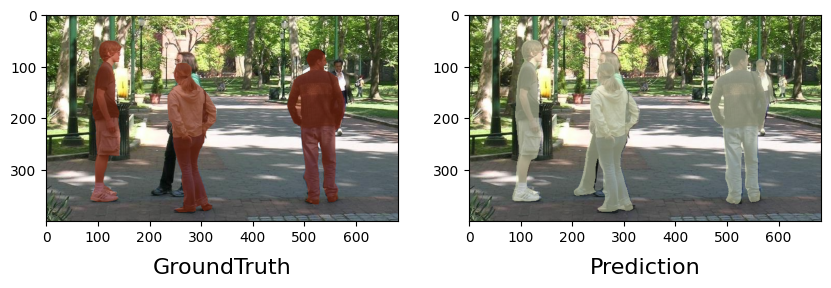

In [9]:
fig = plt.figure(figsize=(10, 4))
axes = fig.add_subplot(1, 2, 1)
axes.imshow(masked_test_image)
axes.set_title("GroundTruth", fontsize=16, y=-0.3)
axes = fig.add_subplot(1, 2, 2)
masked_output = gcv.utils.viz.plot_mask(test_image, filtered_output)
axes.imshow(masked_output)
axes.set_title("Prediction", fontsize=16, y=-0.3);

In [10]:
# Quantitative Evaluation
segmentation_metrics = SegmentationMetric(1)

start_time = time.time()

for (X, y) in tqdm(pedestrian_dataset):
    
    # Format inputs
    image = X
    gt_mask = y
    
    transformed_image = gcv.data.transforms.presets.segmentation.test_transform(image, ctx)    
    
    output = pspnet.predict(transformed_image)
    segmentation_metrics.update(gt_mask * pedestrian.COCO_PERSON_CLASS, output)

metrics = segmentation_metrics.get()
print("PixAcc: ", metrics[0])
print("mIoU  : ", metrics[1])
print("Elapsed Time: ", time.time() - start_time ,"secs")

  0%|          | 0/170 [00:00<?, ?it/s]

[08:31:45] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[08:31:57] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[08:32:08] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[08:32:20] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[08:32:31] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running perf

PixAcc:  0.9036426226831216
mIoU  :  0.8861080756865602
Elapsed Time:  1033.4768948554993 secs


In [11]:
deeplab = gcv.model_zoo.get_model('deeplab_resnet152_coco', pretrained=True, ctx=ctx)

In [12]:
output = deeplab.predict(transformed_test_image)

In [13]:
filtered_output = pedestrian.PedestrianDataset.process_model_mask(output)

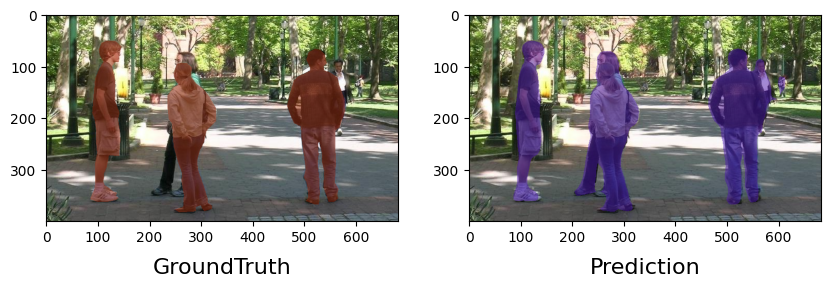

In [14]:
fig = plt.figure(figsize=(10, 4))
axes = fig.add_subplot(1, 2, 1)
axes.imshow(masked_test_image)
axes.set_title("GroundTruth", fontsize=16, y=-0.3)
axes = fig.add_subplot(1, 2, 2)
masked_output = gcv.utils.viz.plot_mask(test_image, filtered_output)
axes.imshow(masked_output)
axes.set_title("Prediction", fontsize=16, y=-0.3);

In [15]:
segmentation_metrics = SegmentationMetric(1)

start_time = time.time()

for (X, y) in tqdm(pedestrian_dataset):
    
    # Format inputs
    image = X
    gt_mask = y
    
    transformed_image = gcv.data.transforms.presets.segmentation.test_transform(image, ctx)    
    
    output = deeplab.predict(transformed_image)    
    segmentation_metrics.update(gt_mask * pedestrian.COCO_PERSON_CLASS, output)
    
metrics = segmentation_metrics.get()
print("PixAcc: ", metrics[0])
print("mIoU  : ", metrics[1])
print("Elapsed Time: ", time.time() - start_time ,"secs")

  0%|          | 0/170 [00:00<?, ?it/s]

[08:48:59] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[08:49:07] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[08:49:13] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[08:49:20] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[08:49:28] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running perf

PixAcc:  0.9010346551357763
mIoU  :  0.8831514752705607
Elapsed Time:  130.4770221710205 secs
